# Time Series

In [1]:
%matplotlib inline

In [2]:
import scipy
import numpy
import pandas
import seaborn
import itertools
from sklearn.metrics import confusion_matrix
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.neighbors import KNeighborsClassifier
from functools import partial
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

/home/podondra/mi-pdd/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
seaborn.set()
seaborn.set_style('ticks')

## Data

In [4]:
train_file = 'data/train.csv'
test_file = 'data/test.csv'

# last column contains the class
train = numpy.genfromtxt('data/train.csv', delimiter='\t')
test = numpy.genfromtxt('data/test.csv', delimiter='\t')
X, y = train[:, :-1], train[:, -1].astype(numpy.int8)
X_te, y_te = test[:, :-1], test[:, -1].astype(numpy.int8)
X.shape, y.shape

((300, 60), (300,))

There is 6 classes each with 50 sample in both train and test set.

In [5]:
numpy.unique(y, return_counts=True)

(array([1, 2, 3, 4, 5, 6], dtype=int8), array([50, 50, 50, 50, 50, 50]))

In [6]:
numpy.unique(y_te, return_counts=True)

(array([1, 2, 3, 4, 5, 6], dtype=int8), array([50, 50, 50, 50, 50, 50]))

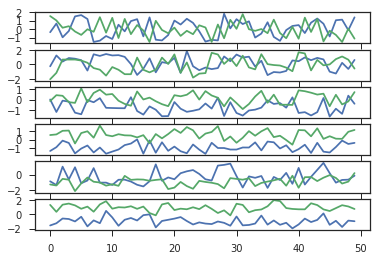

In [7]:
f, axs = pyplot.subplots(nrows=6)
for i, ax in enumerate(axs):
    ax.plot(X[y == i + 1][:, numpy.random.randint(0, 49, size=2)])

## Dynamic Time Warping

https://github.com/alexminnaar/time-series-classification-and-clustering

Dynamic time warping finds the optimal non-linear alignment between two time series.
The aligment on the time axis fixes the distortions that cannot be captured when comparing coefficients having the same index (as many metrics do).
Dynamic time warping is quadratic in the length of the time series used.

Dynamic time warping works in the following way.
Consider two time series $Q = q_1, q_2, \dots, q_n$ and $C = c_1, c_2, \dots, c_n$ of the same length $n$ where
We construct an $n \times n$ matrix $M$ whose $i, j$ element is the (Euclidean) distance between $q_i$ and $c_j$.
We want to find a path through this matrix that minimizes the cumulative distance.
This path then determines the optimal alignment between the two time series.
Of course, we restrict ourselves to path that have non-decreasing indices and have fixed starting end ending points.

The optimal path is usually found via dynamic programming, specifically the following recursive function:

$$\gamma(i, j) = \mathrm{d}(q_i, c_j) + \min(\gamma(i - 1, j - 1), \gamma(i - 1, j), \gamma(i, j - 1))$$

where $\mathrm{d}$ is some distance.

We can improve the DTW distance by adding another restriction for the path.
We require the path to be close the diagonal of $M$.
The closeness is given by the width $w$ of the stripe along the diagonal that is to contain the optimal path.
In other words, we give a limit on the maximal possible time distortion that DTW can capture.

In [8]:
def DTWDistance(s1, s2, w):
    DTW = {}
    
    w = max(w, abs(len(s1) - len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1, len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i - w), min(len(s2), i + w)):
            dist = (s1[i] - s2[j]) ** 2
            DTW[(i, j)] = dist + min(DTW[(i - 1, j)], DTW[(i, j - 1)], DTW[(i - 1, j - 1)])

    return numpy.sqrt(DTW[len(s1) - 1, len(s2) - 1])

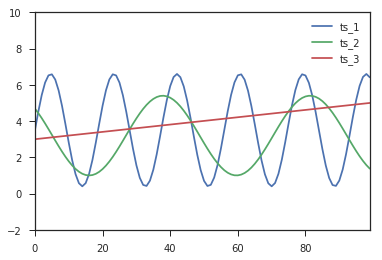

In [9]:
# sample data
x = numpy.linspace(0, 50, 100)
ts_1 = pandas.Series(3.1 * numpy.sin(x / 1.5) + 3.5)
ts_2 = pandas.Series(2.2 * numpy.sin(x / 3.5 + 2.4) + 3.2)
ts_3 = pandas.Series(0.04 * x + 3.0)

ts_1.plot()
ts_2.plot()
ts_3.plot()
pyplot.ylim(-2, 10)
pyplot.legend(['ts_1','ts_2','ts_3'])

In [10]:
DTWDistance(ts_1, ts_1, 5), DTWDistance(ts_1, ts_2, 5), DTWDistance(ts_1, ts_3, 5)

(0.0, 21.325435982766471, 22.688332647362234)

### LB Keogh

Another similarity measure requires to build an envolepe around the base series and then test whether the tested signal falls well into this envelope.

The distance from the envelope is given by the following the LB Keogh lower bound of dynamic time warping.
It is defined as:

$$LBKeogh(Q, C) = \sqrt{\sum_{i = 1}^n (c_i - U_i)^2 I(c_i > U_i) + (c_i - L_i)^2 I(c_i < L_i)}$$

where $U_i$ and $L_i$ are upper and lower bounds for time series $Q$
which are defined as $U_i = max(q_{i - r}, q_{i + r})$
and $L_i = min(q_{i - r}, q_{i + r})$ for a reach $r$ and $I(\cdot)$ is the indicator function.

Its name comes from the fact that it was originally conceived as a cheaper indicator for the DTW metric,
having this property:

$$LBKeogh(Q, C) \leq DTW(Q, C)$$

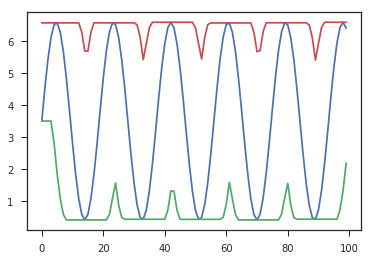

In [11]:
r = 7
# lower bound for the envelope
L = [min(ts_1[idx - r if idx - r >= 0 else 0:idx + r]) for idx in range(len(ts_1))]
# upper bound for the envelope
U = [max(ts_1[idx - r if idx - r >= 0 else 0:idx + r]) for idx in range(len(ts_1))]

pyplot.plot(ts_1)
pyplot.plot(ts_1.index, L)
pyplot.plot(ts_1.index, U)

In [12]:
def LB_Keogh(s1, s2, r):
    LB_sum = 0
    for idx, i in enumerate(s1):
        lower_bound = min(s2[idx - r if idx - r >= 0 else 0:idx + r])
        upper_bound = max(s2[idx - r if idx - r >= 0 else 0:idx + r])
        
        if i > upper_bound:
            LB_sum = LB_sum + (i - upper_bound) ** 2
        elif i < lower_bound:
            LB_sum = LB_sum + (i - lower_bound) ** 2

    return numpy.sqrt(LB_sum)

In [13]:
LB_Keogh(ts_1, ts_1, 5), LB_Keogh(ts_1, ts_2, 5), LB_Keogh(ts_1, ts_3, 5)

(0.0, 18.699672203819983, 22.390567805772839)

## Performance

I will try to use $k$-nearest neighbors with each distance and see its performance on test set.
I hope the the `train` and `test` data are from same distribution and so only splitted.
Then, if classification trained on training data works well on testing data,
the distances should be good for both classification and clustering.

In [14]:
dtw_5 = partial(DTWDistance, w=5)
knn_dtw = KNeighborsClassifier(n_neighbors=5, metric=dtw_5, n_jobs=-1)
knn_dtw.fit(X, y)

%time y_pred = knn_dtw.predict(X_te)
accuracy_score(y_te, y_pred)

CPU times: user 6min 33s, sys: 5.11 s, total: 6min 38s
Wall time: 6min 36s


0.97666666666666668

Accuracy with DTW distance ($w = 5$) is 97.7%. It is time consuming computation so I do not evaluate different $w$ as this performance is sufficient in my opinion and can be used for clustering or classification.

In [15]:
for r in range(1, 10):
    keo = partial(LB_Keogh, r=r)
    knn_keo = KNeighborsClassifier(n_neighbors=5, metric=keo, n_jobs=-1)
    knn_keo.fit(X, y)

    %time y_pred = knn_keo.predict(X_te)
    print('r: {}\t accuracy: {}'.format(r, accuracy_score(y_te, y_pred)))

CPU times: user 25.1 s, sys: 349 ms, total: 25.5 s
Wall time: 25.1 s
r: 1	 accuracy: 0.9766666666666667
CPU times: user 12.8 s, sys: 140 ms, total: 13 s
Wall time: 12.8 s
r: 2	 accuracy: 0.8766666666666667
CPU times: user 6.21 s, sys: 84.5 ms, total: 6.3 s
Wall time: 6.28 s
r: 3	 accuracy: 0.6533333333333333
CPU times: user 5.67 s, sys: 77.5 ms, total: 5.74 s
Wall time: 5.74 s
r: 4	 accuracy: 0.6666666666666666
CPU times: user 6.68 s, sys: 102 ms, total: 6.79 s
Wall time: 6.82 s
r: 5	 accuracy: 0.67
CPU times: user 7.17 s, sys: 86.2 ms, total: 7.26 s
Wall time: 7.26 s
r: 6	 accuracy: 0.6233333333333333
CPU times: user 6.77 s, sys: 86.5 ms, total: 6.86 s
Wall time: 6.83 s
r: 7	 accuracy: 0.6266666666666667
CPU times: user 7.28 s, sys: 90.5 ms, total: 7.37 s
Wall time: 7.36 s
r: 8	 accuracy: 0.61
CPU times: user 7.64 s, sys: 77.6 ms, total: 7.72 s
Wall time: 7.76 s
r: 9	 accuracy: 0.5833333333333334


Accuracy for LB Keogh distance ($r = 1$) is 97.7% so it should work for clusttering and classification.

## Wedge

Having candidate sequences $C_1, \dots, C_k$,
we can form two new sequences $U$ and $L$:

$$U_i = \max(C_{1i}, \dots, C_{ki})$$
$$L_i = \min(C_{1i}, \dots, C_{ki})$$

They form the smallest possible bounding envelope that encloses sequences $C_1, \dots, C_k$.

We call the combination of $U$ and $L$ a wedge
and denote a wedge as $W$.

$$W = \{U, L\}$$

A lower bounding measure between an arbitary query $Q$
and the entire set of candidate sequences contained in a wedge $W$:

$$LBKeogh(Q, W) = \sqrt{\sum_{i = 1}^n (q_i - U_i)^2 I(1_i > U_i) + (c_i - L_i)^2 I(c_i < L_i)}$$

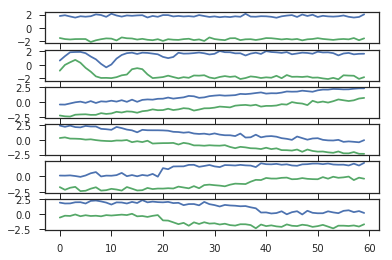

In [16]:
def wedge(X):
    return X.max(axis=0), X.min(axis=0)

f, axs = pyplot.subplots(nrows=6, sharex=True)
for i, ax in enumerate(axs):
    W = wedge(X[y == i + 1])
    ax.plot(W[0])
    ax.plot(W[1])

In [17]:
Ws = [wedge(X[y == i]) for i in range(1, 7)]
len(Ws)

6

In [18]:
def LB_Keogh_W(q, W):
    LB_sum = 0
    for idx, val in enumerate(q):
        lower_bound = W[1][idx]
        upper_bound = W[0][idx]
        
        if i > upper_bound:
            LB_sum = LB_sum + (val - upper_bound) ** 2
        elif i < lower_bound:
            LB_sum = LB_sum + (val - lower_bound) ** 2

    return numpy.sqrt(LB_sum)

foo = X_te[-1]
pred = numpy.zeros(6)
for idx, W in enumerate(Ws):
    pred[idx] = LB_Keogh_W(foo, W)
y_te[-1], pred, numpy.argmin(pred) + 1

(6, array([ 15.74410896,  15.50549095,  15.17219614,   9.27821994,
         15.67575963,  11.08056477]), 4)

In [19]:
y_pred = numpy.zeros_like(y_te)
for i, x in enumerate(X):
    pred = numpy.zeros(6)
    for j, W in enumerate(Ws):
        pred[j] = LB_Keogh_W(x, W)
    y_pred[i] = numpy.argmin(pred) + 1

accuracy_score(y_te, y_pred)

0.34000000000000002

Accuracy with wedge approach is 34% which is pretty bad in comparison with the method above.

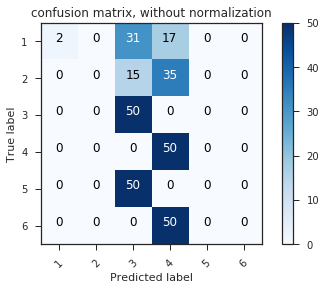

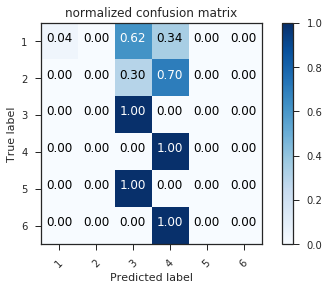

In [20]:
# see http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = numpy.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')

# compute confusion matrix
cnf_matrix = confusion_matrix(y_te, y_pred)

# plot non-normalized confusion matrix
pyplot.figure()
plot_confusion_matrix(cnf_matrix, classes=[1, 2, 3, 4, 5, 6],
                      title='confusion matrix, without normalization')

# plot normalized confusion matrix
pyplot.figure()
plot_confusion_matrix(cnf_matrix, classes=[1, 2, 3, 4, 5, 6], normalize=True,
                      title='normalized confusion matrix')

Confusion matrixes show that most sequences are classified into 3 and 4.
Their weges look similar and have monotonic behavior.
Probably their are good traid off for other classes.
Like all from class 5 are classified incorectly as class 3 and accordingly class 6.
See the wedges picture above.

## Clustering (Optional)

Perform a clustering method of your choice on `train` and compare the obtained cluster with the provided class information.

Data visualization with PCA.

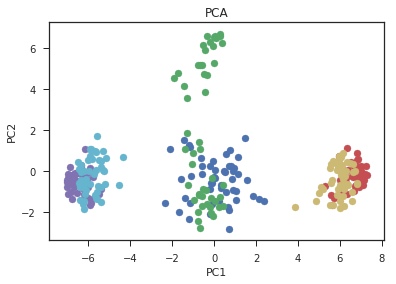

In [21]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
for i in range(1, 7):
    pyplot.scatter(X_pca[y == i, 0], X_pca[y == i, 1])
pyplot.title('PCA')
pyplot.xlabel('PC1')
pyplot.ylabel('PC2')

If I will do this I should use agglomerative clustering where I can specify metric as `affinity` parameter.
Sorry I will not do that.